In [37]:
# Importação das bibliotecas 
import numpy as np # Essa biblioteca consiste em objetos chamados de arrays (matrizes), que são multidimensionais
import pandas as pd # Biblioteca que oferece estruturas e operações para manipular tabelas numéricas e séries temporais
import matplotlib.pyplot as plt # Biblioteca é utilizada para criação de gráficos e visualização de dados
import tensorflow as tf # Biblioteca para computação numérica usando grafos de fluxo de dados para um rede neural
import seaborn as sns # Ele fornece uma interface de alto nível para desenhar gráficos estatísticos atraentes e informativos.
import os # Biblioteca de comandos do sistema operacional utilizada para fazer automação de processos no Python
import glob # É usado para retornar todos os caminhos de arquivo que correspondem a um padrão específico.
import plotly.graph_objects as go # Biblioteca de gráficos interativos com qualidade de publicação
import cv2 # É uma biblioteca que possui funções de manipulações básicas de imagens e vídeos, desde o carregamento de arquivos.
import warnings # Biblioteca responsavel por gerar avisos
from PIL import Image # Oferece amplo suporte a formatos de arquivo, uma representação interna eficiente e recursos de processamento de imagem bastante poderosos,
from PIL import ImageFile 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.optimizers import adam_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten , Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [38]:
# Carregando Dataset 

root_dir = 'D:\GIT\ProjetoII\dataset' # Acessando diretorio de onde está localizado o dataset que iremos trabalhar.
treino_dir = os.path.join(root_dir,'treino') # Método para unir um ou mais componentes de caminho de forma inteligente.
print('''Caminho do dadaset é : ''',treino_dir)
print()

tipo1_dir = os.path.join(treino_dir, 'tipo_1')# Acessando diretorio "Tipo_*", onde estão nosssa imagens.
tipo2_dir = os.path.join(treino_dir, 'tipo_2')
tipo3_dir = os.path.join(treino_dir, 'tipo_3')
print('''Caminho do dadaset para o tipo 1 é : ''',tipo1_dir)
print()

treino_tipo1_files = glob.glob(tipo1_dir+'/*.jpg') # Encontra todos os nomes de caminho que correspondem a um padrão especificado de acordo com as regras usadas pelo shell Unix
treino_tipo2_files = glob.glob(tipo2_dir+'/*.jpg')
treino_tipo3_files = glob.glob(tipo3_dir+'/*.jpg')


added_tipo1_files  =  glob.glob(os.path.join(root_dir, "adicionar_tipo_1", "tipo_1")+'/*.jpg')
added_tipo2_files  =  glob.glob(os.path.join(root_dir, "adicionar_tipo_2", "tipo_2")+'/*.jpg')
added_tipo3_files  =  glob.glob(os.path.join(root_dir, "adicionar_tipo_3", "tipo_3")+'/*.jpg')


tipo1_files = treino_tipo1_files + added_tipo1_files
tipo2_files = treino_tipo2_files + added_tipo2_files
tipo3_files = treino_tipo3_files + added_tipo3_files

print(f'''Foram adicionado {len(tipo1_files)} imagens do Tipo 1  
Foram adicionado {len(tipo2_files)} imagens do Tipo 2
Foram adicionado {len(tipo3_files)} imagens do Tipo 3''' )

Caminho do dadaset é :  D:\GIT\ProjetoII\dataset\treino

Caminho do dadaset para o tipo 1 é :  D:\GIT\ProjetoII\dataset\treino\tipo_1

Foram adicionado 1441 imagens do Tipo 1  
Foram adicionado 4348 imagens do Tipo 2
Foram adicionado 2426 imagens do Tipo 3


In [39]:
# Criar dataframe dos arquivo e rótulos
arquivos = {'caminho': tipo1_files + tipo2_files + tipo3_files,
          'rotulos': ['Tipo 1']* len(tipo1_files) + ['Tipo 2']* len(tipo2_files) + ['Tipo 3']* len(tipo3_files)}

cance_df = pd.DataFrame(arquivos).sample(frac=1, random_state= 1).reset_index(drop=True)
cance_df

,caminho,rotulos
0,D:\GIT\ProjetoII\dataset\treino\tipo_1\1414.jpg,Tipo 1
1,D:\GIT\ProjetoII\dataset\adicionar_tipo_3\tipo...,Tipo 3
2,D:\GIT\ProjetoII\dataset\adicionar_tipo_1\tipo...,Tipo 1
3,D:\GIT\ProjetoII\dataset\adicionar_tipo_2\tipo...,Tipo 2
4,D:\GIT\ProjetoII\dataset\adicionar_tipo_3\tipo...,Tipo 3
...,...,...
8210,D:\GIT\ProjetoII\dataset\adicionar_tipo_2\tipo...,Tipo 2
8211,D:\GIT\ProjetoII\dataset\adicionar_tipo_3\tipo...,Tipo 3
8212,D:\GIT\ProjetoII\dataset\adicionar_tipo_1\tipo...,Tipo 1
8213,D:\GIT\ProjetoII\dataset\adicionar_tipo_2\tipo...,Tipo 2


In [40]:
# Describe(), método calcula e exibe estatísticas resumidas para um dataframe
cance_df.describe()

,caminho,rotulos
count,8215,8215
unique,8215,3
top,D:\GIT\ProjetoII\dataset\adicionar_tipo_2\tipo...,Tipo 2
freq,1,4348


In [41]:
# check for duplicates
len(cance_df[cance_df.duplicated(subset=['caminho'])])

0

In [42]:
# Verificando se existe arquivos danificado
bad_files = []
for path in (cance_df['caminho'].values):
    try:
        img = Image.open(path)
    except:
        index = cance_df[cance_df['caminho']==path].index.values[0]
        bad_files.append(index)
print(len(bad_files))

3


In [43]:
# Deletando arquivos danificados
cance_df.drop(bad_files, inplace=True)

In [44]:
tipo_count = pd.DataFrame(cance_df['rotulos'].value_counts()).rename(columns= {'rotulos': 'quantidade'})
tipo_count

,quantidade
Tipo 2,4346
Tipo 3,2426
Tipo 1,1440


'plt.figure(figsize = (19, 10))\ncance_df["rotulos"].value_counts().plot.pie(title=\'Distribuição do tipo de câncer do colo do útero\', autopct=\'%.2f%%\', legend = False, fontsize=14) \nplt.axis(\'equal\')\n\nplt.show()'

In [131]:
# Grafico do dataset
pie_plot = go.Pie(labels= tipo_count.index.to_list(), values= tipo_count.values.flatten(),
                 hole= 0.2, text= tipo_count.index.to_list(), textposition='auto')
fig = go.Figure([pie_plot])
fig.update_layout(title_text='Distribuição do tipo de câncer do colo do útero', font_size=15, autosize=False, width=600, height=600)
fig.show()


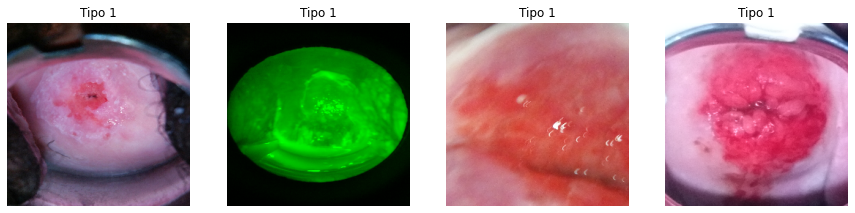

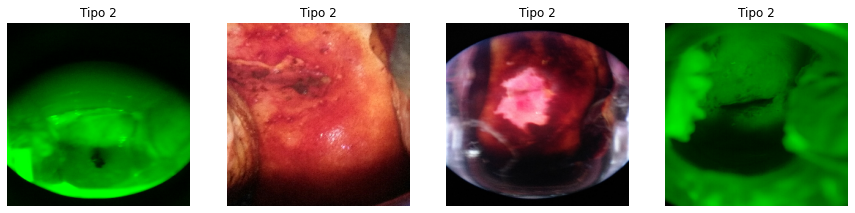

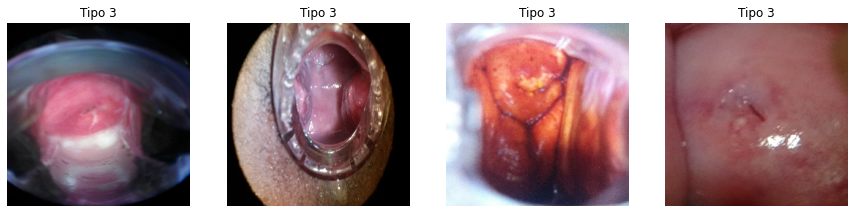

In [134]:
# Exemplo de imagens por tipo
for rotulo in ('Tipo 1', 'Tipo 2', 'Tipo 3'):
    filepaths = cance_df[cance_df['rotulos']==rotulo]['caminho'].values[:4]
    fig = plt.figure(figsize= (19, 10))
    for i, path in enumerate(filepaths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (250, 250))
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        plt.subplots_adjust(hspace=0.5)
        plt.axis(False)
        plt.title(rotulo)

In [120]:
#Data Processing
#  split the data into train  and validation set
train_df, eval_df = train_test_split(cance_df, test_size= 0.2, stratify= cance_df['rotulos'], random_state= 1)
val_df, test_df = train_test_split(eval_df, test_size= 0.5, stratify= eval_df['rotulos'], random_state= 1)
print(len(train_df), len(val_df), len(test_df))

6569 821 822
